# Canadian Housing Price Prediction Using Linear Regression

This notebook contains a research project that examines how well a simple linear regression model can predict housing prices across Canada. The analysis is reproducible and uses publicly available data from Kaggle.

In [9]:
# ============================================================
# Imports and Setup
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter

# Set fixed seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Data Loading

We load the dataset using a relative path. Ensure that the CSV file is in the `data/` folder in the repository.

In [10]:
# Load dataset from the data folder
df = pd.read_csv("../data/Canadian House Prices.csv", encoding='latin1')

Saving Canadian House Prices.csv to Canadian House Prices (1).csv


## Data Cleaning

We remove duplicates and entries with missing critical values. Extreme price outliers (top 1%) are also removed to stabilize linear regression.

In [11]:
# Data cleaning
df = df.drop_duplicates()
df = df.dropna(subset=['Price', 'Number_Beds', 'Number_Baths', 'City', 'Province', 'Population'])

# Remove extreme outliers (top 1%)
upper_limit = df['Price'].quantile(0.99)
df = df[df['Price'] <= upper_limit]

## Feature Engineering

We create new features: total rooms, log population, and province-average price (computed using training data only to avoid data leakage). The target variable is also log-transformed.

In [12]:
# Feature engineering
df['Total_Rooms'] = df['Number_Beds'] + df['Number_Baths']
df['Log_Population'] = np.log1p(df['Population'])
df['Log_Price'] = np.log1p(df['Price'])

# Select features and target
features = df[['Number_Beds', 'Number_Baths', 'City', 'Province', 'Log_Population', 'Total_Rooms']]
target = df['Log_Price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED
)

# Compute province-level average prices using training data only
province_avg = (
    X_train.assign(Price=np.expm1(y_train))
    .groupby('Province')['Price']
    .mean()
)

# Map province averages to train and test sets
X_train['Province_Avg_Price'] = X_train['Province'].map(province_avg)
X_test['Province_Avg_Price'] = X_test['Province'].map(province_avg)

# Handle unseen provinces in test set
overall_avg = np.expm1(y_train).mean()
X_test['Province_Avg_Price'] = X_test['Province_Avg_Price'].fillna(overall_avg)

## Encoding Categorical Variables

Categorical variables (City, Province) are one-hot encoded after the train-test split to prevent data leakage. The training and test sets are aligned to ensure the same feature space.

In [13]:
# One-hot encoding
X_train = pd.get_dummies(X_train, columns=['City', 'Province'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['City', 'Province'], drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

## Model Training

A linear regression model is trained in log space. Cross-validation is performed to evaluate stability across different subsets.

In [14]:
# Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("\nCross-Validated Performance (5-fold)")
print(f"\tR² Scores: [{', '.join([f'{score:.4f}' for score in cv_scores])}]")
print(f"\tMean R²: {cv_scores.mean():.4f}")
print(f"\tStandard Deviation: {cv_scores.std():.4f}")


Cross-Validated Performance (5-fold)
	R² Scores: [0.6420, 0.6274, 0.6469, 0.6331, 0.6400]
	Mean R²: 0.6379
	Standard Deviation: 0.0069


## Model Evaluation

Predictions are evaluated in both log space and real dollars to provide a complete understanding of performance.

In [15]:
# Predictions
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# Metrics
r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
median_ae = np.median(np.abs(y_actual - y_pred))
mae_dollars = np.mean(np.abs(y_actual - y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print("\nModel Performance:")
print(f"\tR² (log space): {r2_log:.4f}")
print(f"\tRMSE (log space): {rmse_log:.4f}")
print("\nErrors in Dollars:")
print(f"\tMedAE: ${median_ae:,.2f}")
print(f"\tMAE: ${mae_dollars:,.2f}")
print(f"\tMAPE: {mape:.2f}%")


Model Performance:
	R² (log space): 0.6227
	RMSE (log space): 0.4283

Errors in Dollars:
	MedAE: $145,971.58
	MAE: $483,029.32
	MAPE: 36.29%


## Visualization and Error Analysis

Scatter plots show actual vs predicted values and log-residuals. Errors are summarized across price ranges.

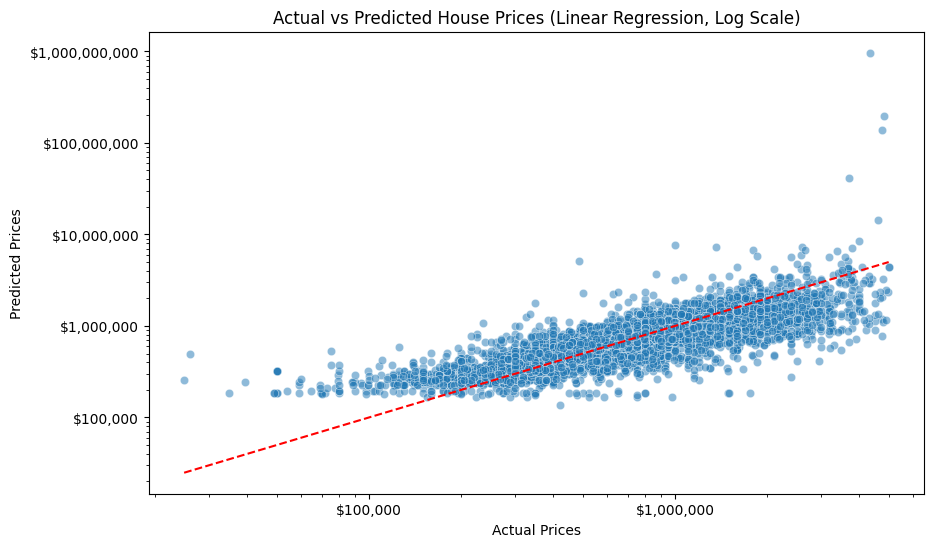

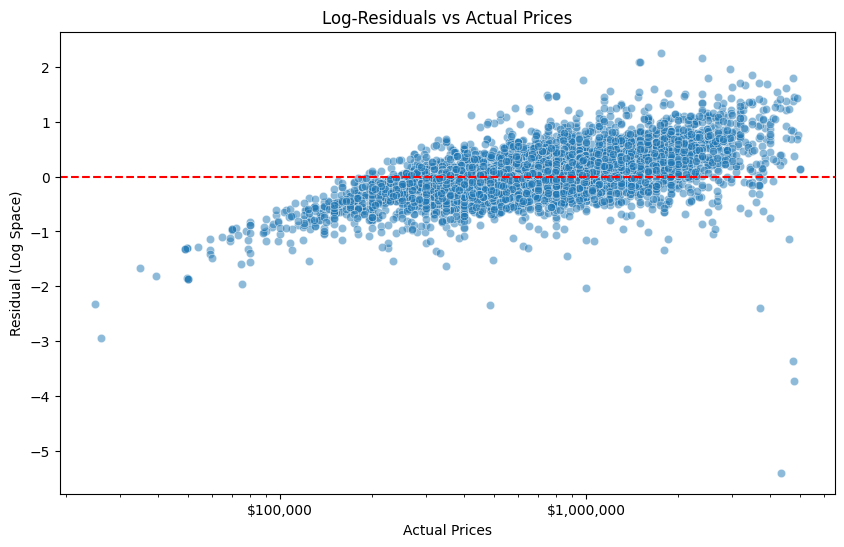


Average Error by Price Range:
                   mean  count
Price Range                   
Very Low       $116,766   1323
Low            $139,685   1319
Medium         $154,438   1314
High           $227,693   1312
Very High    $1,777,038   1317


In [16]:
# Dollar formatter
def dollar_formatter(x, pos):
    return f'${x:,.0f}'

# Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_actual, y=y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], '--', color='red')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Linear Regression, Log Scale)")
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
plt.show()

# Log-residuals vs Actual
log_residuals = y_test - y_pred_log
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_actual, y=log_residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xscale('log')
plt.xlabel("Actual Prices")
plt.ylabel("Residual (Log Space)")
plt.title("Log-Residuals vs Actual Prices")
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
plt.show()

# Error summary by price range
df_results = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_pred,
    'Error': np.abs(y_actual - y_pred)
})
df_results['Price Range'] = pd.qcut(df_results['Actual'], 5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
error_summary = df_results.groupby('Price Range', observed=True)['Error'].agg(['mean', 'count'])
error_summary['mean'] = error_summary['mean'].apply(lambda x: f"${x:,.0f}")
print("\nAverage Error by Price Range:")
print(error_summary)